<a href="https://colab.research.google.com/github/moshemm/NN-methods-hse/blob/main/CNN_HW2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Комбинация эмбеддингов и символьных признаков: У этой модели два входа, один для эмбеддингов слов (предобученных или обучаемых - я взяла предобученные, так как датасет маленький и эмбеддингам не хватает данных, чтобы обучиться + попрактиковаться в предобученных эмб.), из них берем max или mean, делаем вектор для предложения, поверх линейный слой - получаем вектор X. Другой вход сети для символьного представления слов (это обучаемый Embedding слой, он будет брать на вход batch_size x symbols_len и сопоставлять каждому символу в каждом слове один эмбеддинг). Следующий слой сверточный, примените фильтры разных размеров. Результаты агрегируются с помощью max pooling over time и полученные векторы конкатенируются с вектором X. 

Combination of embeddings and character features: This model has two inputs, one for word embeddings (pre-trained or trainable - I took pre-trained ones, since the dataset is small and embeddings do not have enough data to get trained + practice pre-trained embeddings), we take max or mean, make a vector for the sentence, on top of a linear layer - we get a vector X. 

Another network input for the character representation of words (this is a trained Embedding layer, it will take batch_size x symbols_len as input and match each symbol in each word with one embedding). The next layer is convolutional, apply filters of different sizes. The results are aggregated using max pooling over time and the resulting vectors are concatenated with the X vector.

## Импорты и загрузка датасета

In [284]:
!pip install torchmetrics -q
!pip install datasets -q

In [285]:
!pip install ipdb -q

In [286]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import re
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
import gensim

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1Score as F1
from torchmetrics.functional import f1_score as f1
from torchmetrics.functional import recall
import ipdb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [287]:
corpus = load_dataset('cedr')

No config specified, defaulting to: cedr/main
Reusing dataset cedr (/root/.cache/huggingface/datasets/cedr/main/0.1.1/117570489cbabbdf8de619bd31918a1cd680a7f286b89d04af340d0691dc2d66)


  0%|          | 0/2 [00:00<?, ?it/s]

## Датасет

In [288]:
corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 7528
    })
    test: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 1882
    })
})

In [289]:
corpus['train'][:10]

{'labels': [[], [], [2], [0], [], [3], [1], [1], [0], [1]],
 'source': ['lj',
  'lenta',
  'lj',
  'twitter',
  'lenta',
  'lenta',
  'lj',
  'twitter',
  'twitter',
  'twitter'],
 'text': ['Суровый гималайский медведь .',
  'Так, обнаружено несколько проблем с дисплеем (выгорание, странные зеленые полосы), дефекты динамика и некорректная работа Face ID.',
  'У меня остается только один вопрос - является ли этот приступ отчаяния ( а точнее приступ удивления , почему мне не становится лучше , почему мне ничего не помогает ) еще одним испытанием ?',
  'Забавно как люди в возрасте удивляются входящим звонкам на мобильник)',
  'Издание The Register отмечает, что у владельцев гаджетов пока нет повода для паники из-за уязвимости батареи, потому что пока атака остается лишь теорией, которую попытались проверить ученые.',
  'Мы в ужасе от того, что на этот раз был убит человек.',
  'Все они , к сожалению , для школьников или просто детей .',
  'Кому они так необходимы, эти страдания?» А у меня

Этот датасет я использовала, когда работала с MLP, но перцентрону было слишком сложно. Попробуем предсказать эмоции (тут чуть сложнее, чем просто позитивный/негативный:  {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Emotions: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}')

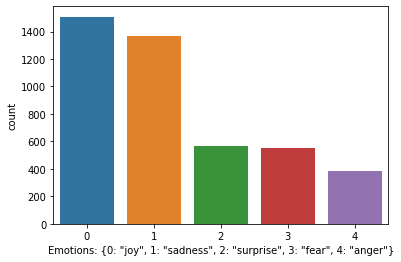

In [290]:
from collections import Counter

labels = [label[0] for label in corpus['train']['labels'] if len(label) == 1]
cnt_labels = Counter(labels)

sns.countplot(labels);
plt.xlabel('Emotions: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}')

возьмем только те тексты, у которых размечена одна эмоция

In [291]:
texts = list()
labels = list()

for text, label in zip(corpus['train']['text'], corpus['train']['labels']):
    if len(label) == 1:
        texts.append(text)
        labels.append(label[0])
        
len(texts)

4378

## Preprocessing

In [292]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [293]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return tokens

Проверим, побьет ли токенизатор пунктуаторы (их нет в предобученных эмбеддингах)

In [294]:
print(word_tokenize('!!)) :))) !!!'))

['!', '!', ')', ')', ':', ')', ')', ')', '!', '!', '!']


In [295]:
vocab = Counter()

for text in texts:
    vocab.update(preprocess(text))

print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 15665


Для удобства сделаем DataFrame + с ним быстрее работать

In [296]:
data = pd.DataFrame(list(zip(texts, labels)), columns=['text', 'label'])
data.head()

,text,label
0,У меня остается только один вопрос - является ...,2
1,Забавно как люди в возрасте удивляются входящи...,0
2,"Мы в ужасе от того, что на этот раз был убит ч...",3
3,"Все они , к сожалению , для школьников или про...",1
4,"Кому они так необходимы, эти страдания?» А у м...",1


In [297]:
data['tokenized'] = data['text'].apply(preprocess)
data.sample(10)

,text,label,tokenized
497,"Ну соком наверно тогда, если после него.. Ужас...",1,"[ну, соком, наверно, тогда, ,, если, после, не..."
3158,"Сегодня странный день, всё ломается, разбивает...",1,"[сегодня, странный, день, ,, всё, ломается, ,,..."
745,Обилие кнопок пугает только на первый взгляд .,3,"[обилие, кнопок, пугает, только, на, первый, в..."
3190,"Я настолько чего-то боюсь, что сейчас съем все...",3,"[я, настолько, чего-то, боюсь, ,, что, сейчас,..."
2575,Я умру на глазах у злобного петросяна :D,0,"[я, умру, на, глазах, у, злобного, петросяна, ..."
4029,Мы сидели у меня в подьезде т.к. я малыми дома...,0,"[мы, сидели, у, меня, в, подьезде, т.к, ., я, ..."
3631,идите нахуй мне его жалко я тогда на мамку зли...,4,"[идите, нахуй, мне, его, жалко, я, тогда, на, ..."
2587,"Боюсь подумать , что еще может случиться со мн...",3,"[боюсь, подумать, ,, что, еще, может, случитьс..."
1706,Она посмеялась.,0,"[она, посмеялась, .]"
3663,"Язва желудка - это более чем просто страх , чу...",3,"[язва, желудка, -, это, более, чем, просто, ст..."


Бьем датасет на трейн, валидацию и тест: мы можем иметь/обучать эмбединги только для токенов, которые встретились в трейне.

In [298]:
train_data, notrain_data = train_test_split(data, test_size=0.2)
val_data, test_data = train_test_split(data, test_size=0.5)
print(train_data.shape, val_data.shape, test_data.shape)

(3502, 3) (2189, 3) (2189, 3)


In [299]:
print(train_data['label'].value_counts())
print(val_data['label'].value_counts())
print(test_data['label'].value_counts())

0    1214
1    1096
2     458
3     436
4     298
Name: label, dtype: int64
0    732
1    689
2    284
3    282
4    202
Name: label, dtype: int64
0    776
1    676
2    284
3    271
4    182
Name: label, dtype: int64


In [300]:
train_data.sample(10)

,text,label,tokenized
2354,",у меня через 2часа сессия((пиздец боюсь((((((",3,"[,, у, меня, через, 2часа, сессия, (, (, пизде..."
3085,"самое ужасное чувство - чувство своей ""ненужно...",1,"[самое, ужасное, чувство, -, чувство, своей, `..."
3441,"взгрустнулось, как ни странно.",1,"[взгрустнулось, ,, как, ни, странно, .]"
898,мои угрозы никак не действуют на карину :(,1,"[мои, угрозы, никак, не, действуют, на, карину..."
2303,А хотя..я рада за него) он получил то что хоте...,0,"[а, хотя, .., я, рада, за, него, ), он, получи..."
4177,)Я со злости отвечаю: Туда куда мне нужно даже...,4,"[), я, со, злости, отвечаю, :, туда, куда, мне..."
3030,"я в четыре пробила :D сейчас не боялась, но ес...",0,"[я, в, четыре, пробила, :, d, сейчас, не, боял..."
2278,"Теперь можно не бояться ни штрафов , ни мамкин...",0,"[теперь, можно, не, бояться, ни, штрафов, ,, н..."
1655,А он его так долго изучал и всё удивлялся .,2,"[а, он, его, так, долго, изучал, и, всё, удивл..."
1656,"Поэтому она подыхает , поэтому там так жутко .",3,"[поэтому, она, подыхает, ,, поэтому, там, так,..."


### Word2id - готовимся к пословному эмбеддинг-слою

In [301]:
vocab = Counter()

for row in train_data.tokenized:
  for tok in row:
    vocab[tok] += 1

print(f'Уникальных слов: {len(vocab)}')

Уникальных слов: 13207


In [302]:
vocab.most_common(20)

[(',', 4251),
 ('(', 1853),
 (')', 1667),
 ('.', 1520),
 ('и', 1364),
 ('не', 1003),
 ('в', 986),
 ('я', 965),
 (':', 956),
 ('что', 727),
 ('на', 587),
 ('!', 467),
 ('с', 452),
 ('а', 410),
 ('это', 374),
 ('как', 367),
 ('меня', 330),
 ('-', 318),
 ('но', 309),
 ('...', 279)]

In [303]:
filtered_vocab = set()

for word in vocab:
  if vocab[word] >= 2:
    filtered_vocab.add(word)

print(f'Слова встретились 2 и больше раз: {len(filtered_vocab)}')

Слова встретились 2 и больше раз: 3445


У нас очень ограниченный набор слов, большая часть (~65%) встречается только 1 раз. Попробуем взять эти 3,500 слов, но, возможно, придется взять предобученные эмбеддинги

In [304]:
word2id = {'PAD': 0,
           'UNK': 1}

for word in filtered_vocab:
  word2id[word] = len(word2id)

In [305]:
id2word = {idx:word for word, idx in word2id.items()}

### Symbol2id

In [306]:
symbols = Counter()

for row in train_data.text:
  symbols.update(list(row))

print(f'Уникальных символов: {len(symbols)}')

Уникальных символов: 192


In [307]:
symbols.most_common()[-10:]

[('ช', 1),
 ('บ', 1),
 ('ว', 1),
 ('ิ', 1),
 ('ด', 1),
 ('ี', 1),
 ('โ', 1),
 ("'", 1),
 ('·', 1),
 ('Q', 1)]

In [308]:
filtered_symbols = set()

filtered_symbols.update([sym for sym in symbols if symbols[sym] > 5])
print(f'Символов встретившихся > 5 раз: {len(filtered_symbols)}')

Символов встретившихся > 5 раз: 146


In [309]:
symbol2id = {'PAD': 0,
             'UNK': 1}

for sym in filtered_symbols:
  symbol2id[sym] = len(symbol2id)

In [310]:
id2symbol = {id:sym for sym, id in symbol2id.items()}

## Dataset и DataLoader

In [311]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

Определим, до какой длинны будем паддить эмбеддинг-слой с токенами-словами и с токенами-символами

In [312]:
def plot(column):
  lengths = [data[column].apply(len)]
  plt.grid()
  plt.title("Распределение длин")
  plt.xlabel("Длина в токенах")
  sns.histplot(lengths);

def pad_size(column):
  plot(column)
  return np.percentile(data[column].apply(len), 95)

Хорошая длина для токенов-слов: 31.0


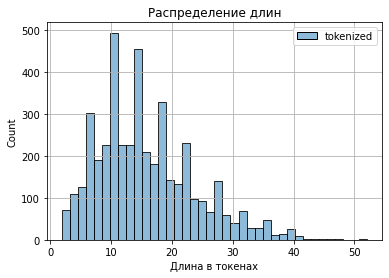

In [313]:
print(f'Хорошая длина для токенов-слов: {pad_size("tokenized")}')

Хорошая длина для токенов-символов: 167.0


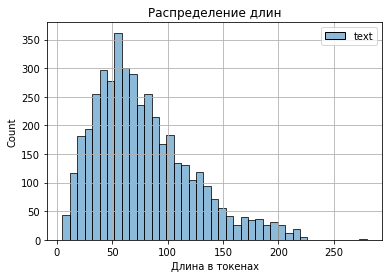

In [314]:
print(f'Хорошая длина для токенов-символов: {pad_size("text")}')

Определим Dataset

In [315]:
class WordSymbolDataset(Dataset):
  def __init__(self, x_words, x_symbols, y, word2id,
               symbol2id, DEVICE, pad=0,
               max_len_word=31, max_len_sym=167):

    super().__init__()

    self.x_words = x_words
    self.x_symbols = x_symbols
    self.y = y

    self.word2id = word2id
    self.symbol2id = symbol2id
    self.pad = pad
    self.max_len_word = max_len_word
    self.max_len_sym = max_len_sym
    self.device = DEVICE


  def __len__(self):
    return len(self.x_words)


  def indexing_words(self, text):
    word_ids = [word2id[tok] if tok in word2id else word2id['UNK'] for tok in text]
    return word_ids


  def indexing_syms(self, text):  
    sym_ids = [symbol2id[tok] for tok in text if tok in symbol2id]
    return sym_ids


  def padding(self, text, max_len):
    text = text[:max_len]
    text = F.pad(text, (0, max_len - len(text)))

    return text


  def __getitem__(self, idx):
    """
    У нас комбинация эмбеддингов и символьных признаков.
    Следовательно, всего по два: словаря-конвертера, перевода в id,
    возвращаем мы тоже по 2 последовательности: для слов и символов
    """
    words = self.x_words.iloc[idx]
    words = self.indexing_words(words)

    syms = self.x_symbols.iloc[idx]
    syms = self.indexing_syms(syms)

    words = torch.tensor(words).to(self.device)
    syms = torch.tensor(syms).to(self.device)
    target = torch.LongTensor([self.y.iloc[idx]]).to(self.device) # нам нужен float, а не int

    words = self.padding(words, self.max_len_word)
    syms = self.padding(syms, self.max_len_sym)

    return words, syms, target
  


In [316]:
train_dataset = WordSymbolDataset(x_words=train_data['tokenized'], x_symbols=train_data['text'],
                            y=train_data['label'], word2id=word2id, symbol2id=symbol2id, DEVICE=DEVICE)

In [317]:
# Проверочка
words, syms, y = train_dataset[5]
print(words, words.shape)
print(syms, syms.shape)
print(y, y.shape)

tensor([2582, 2481,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], device='cuda:0') torch.Size([31])
tensor([126,  77, 119,   2,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 

In [318]:
train_loader = DataLoader(train_dataset, batch_size=16)

In [319]:
batch = next(iter(train_loader))[0]
print(batch, f'\nBatch size: {batch.shape}')

tensor([[1719,  639, 1067,  652,    1, 1104, 2734, 2734, 3016, 1675, 2734, 2734,
         2734, 2734, 2734, 2734,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [1048, 1244, 2583, 1719,  136, 1452, 2504,    1, 3408, 3109,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [2504, 1645,    1, 1641,  636,  768, 2880, 2390, 2504,    1, 1641, 1115,
         1732, 2458, 2734,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   1, 2263, 2048,  675, 2734, 3170, 1687, 3170,    1,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [3109, 1115, 2446, 3393,    1,  675, 2524,  835, 1452,  481,  366,    1,
         2144,    1,    0,    0,    0,    0,    0,    0,    0, 

In [320]:
val_dataset = WordSymbolDataset(x_words=val_data['tokenized'], x_symbols=val_data['text'],
                                y=val_data['label'], word2id=word2id, symbol2id=symbol2id, DEVICE=DEVICE)
val_loader = DataLoader(val_dataset, batch_size=16)
print(next(iter(val_loader))[0].shape)

test_dataset = WordSymbolDataset(x_words=test_data['tokenized'], x_symbols=test_data['text'],
                                 y=test_data['label'], word2id=word2id, symbol2id=symbol2id, DEVICE=DEVICE)
test_loader = DataLoader(test_dataset, batch_size=16)
print(next(iter(test_loader))[0].shape)



torch.Size([16, 31])
torch.Size([16, 31])


## Word2vec

In [321]:
texts = train_data.tokenized.tolist()

In [322]:
texts[:2]

[[',',
  'у',
  'меня',
  'через',
  '2часа',
  'сессия',
  '(',
  '(',
  'пиздец',
  'боюсь',
  '(',
  '(',
  '(',
  '(',
  '(',
  '('],
 ['самое', 'смешное', 'то', ',', 'что', 'мне', 'не', 'отказали', ';', ')']]

In [323]:
%%time
w2v = gensim.models.Word2Vec(texts, size=300, window=5, min_count=2)

CPU times: user 1.3 s, sys: 29 ms, total: 1.33 s
Wall time: 1.17 s


In [324]:
w2v.wv.most_similar('недели')

[('просто', 0.9996918439865112),
 ('ты', 0.9996888041496277),
 ('сейчас', 0.9996873736381531),
 ('будет', 0.999686598777771),
 ('вот', 0.9996862411499023),
 ('..', 0.9996853470802307),
 ('так', 0.9996824264526367),
 ('хочу', 0.9996820688247681),
 ('я', 0.9996813535690308),
 ('нет', 0.9996808767318726)]

так-так, у нас совсем мало слов, чтобы обучить эмбеддинги - для "недели" получились совсем бессмысленные "похожие" слова. Попробуем взять предобученные эмбеддинги.

In [325]:
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2022-06-21 15:50:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  48.1MB/s    in 27s     

2022-06-21 15:50:36 (46.5 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]

gzip: cc.ru.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [326]:
emb_file = open('cc.ru.300.vec')

num_words, emb_dim = emb_file.readline().split()
num_words, emb_dim = int(num_words), int(emb_dim)
emb_file.close()
print(f'num_words: {num_words}, \nemb_dim: {emb_dim}')

num_words: 2000000, 
emb_dim: 300


In [327]:
emb_file = open('cc.ru.300.vec')

num_words, emb_dim = emb_file.readline().split()
line = emb_file.readline().split()
emb_file.close()

In [328]:
np.array([float(dig) for dig in line[1:]])

array([-3.2600e-02, -1.4990e-01,  2.3200e-02,  2.9000e-03, -7.0900e-02,
       -7.8000e-03, -7.5100e-02, -1.9000e-02, -1.9700e-02, -1.5000e-03,
        1.4470e-01,  4.0370e-01,  6.5000e-02, -1.8300e-02,  3.5300e-02,
       -1.5700e-02,  1.3000e-02, -3.7600e-02,  3.8600e-02,  9.6000e-03,
       -6.4400e-02,  2.8430e-01, -7.2000e-02,  3.2200e-02, -1.3500e-02,
       -2.1700e-02,  1.5100e-01,  4.3100e-02, -1.7000e-03,  2.1000e-03,
        2.8500e-02, -5.2600e-02,  7.9000e-03, -5.0000e-03,  2.5000e-03,
       -2.9400e-02, -1.3910e-01, -1.1404e+00, -3.2280e-01, -7.9600e-02,
        2.2100e-02,  3.4700e-02,  1.2400e-02, -1.6090e-01, -1.8600e-01,
        1.0100e-01, -7.2000e-03,  5.6200e-02,  1.0400e-02,  8.7900e-02,
        2.0700e-02,  1.0000e-04,  1.8900e-02,  2.3200e-02, -2.1200e-02,
       -1.0400e-01, -3.4100e-02, -3.3000e-03, -2.0910e-01,  9.8100e-02,
       -4.5520e-01, -1.1140e-01,  3.0900e-02,  9.7400e-02, -1.2510e-01,
        7.8800e-02, -1.0590e-01, -3.9300e-02, -2.3000e-03, -5.97

In [329]:
fasttext = dict()

with open('cc.ru.300.vec') as emb_file:
  for line in emb_file:
    token = line.split()[0]
    emb = line.split()[1:]
    if token in word2id:
      fasttext[token] = np.array([float(dig) for dig in emb])

In [330]:
print(len(fasttext), len(word2id))

3407 3447


В целом, в нашем предобученном фасттексте (на удивление) нашлись почти все слова! Почему на удивление? Часть наших текстов - это твиттер и ЖЖ. То есть это соцсети, "грязные" тексты.

In [331]:
weights = np.zeros((len(word2id), 300))
oov = set()

for word, i in word2id.items():
  if word in ('PAD', 'UNK'):
    continue
  elif word not in fasttext:
    oov.add(word)
  else:
    weights[i] = fasttext[word]


Пришлось сменить токенизатор с wordpunkt_tokenize на word_tokenize, потому что первый не расклеивает пунктуаторы. '!!',
 '!!!',
 '!!!!',
 '!"',
 '!)',
 '!))',
 '!)))',
 '!»',
 '",',
 '",-',
 '"-',
 '".',
 '":',
 '%)',
 "''",
 '((',
 '(((',
 '((((',
 '(((((',
 '((((((',
 '(((((((((((',
 '(...)',
 ')!',
 ')#',
 '))',
 ')))',
 '))))',
 ')))))',
 '))))))',
 ')))))))',
 '),',
 ').',
 '):',
 ')»,',
 '*(',
 '***',
 '*****',
 '*-*',
 '++',
 ',/',
 ',–',
 '-)',
 '-:)',
 '.)',
 '.)))',
 '.))))',
 '..(',
 '..)',
 '..))',
 '..."',
 '...(',
 '...(((',
 '...)',
 '...)))',
 '....((',
 '....(((',

In [332]:
oov

{"''",
 '-/',
 '-_-',
 '//',
 '113кт',
 ':3',
 '^^',
 '^_^',
 '_x005f_x005f_x005f_x005f_x005f_x005f_x005f_x005f_x000d_',
 '`',
 '``',
 'd_x005f_x005f_x005f_x005f_x005f_x005f_x005f_x005f_x000d_',
 'justinstopdoingtattoo',
 'maxgluxix454',
 'o_o',
 'ru_ff',
 'teamfollowback',
 'xdddd',
 'ахмедов',
 'данины',
 'дось',
 'жизнь-боль',
 'жизньболь',
 'лиам',
 'линта',
 'муссолини',
 'наденька',
 'нельсоном',
 'о/',
 'о_о',
 'покуриш',
 'потопаю',
 'пятюню',
 'рибят',
 'рождениия',
 'сааамые',
 'твитте',
 'харбине',
 'хаххах',
 'юп'}

oov совсем немного, скорее всего, нам это сильно мешать не будет

In [333]:
weights.shape

(3447, 300)

## CNN Model

In [334]:
class CNN_w2v(nn.Module):
  def __init__(self, word_vocab_size, sym_vocab_size,
               word_emb_dim, sym_emb_dim):

    super().__init__()

    # word emb of the CNN
    self.w_embedding = nn.Embedding(word_vocab_size, word_emb_dim) # логично emb_dim делать размером корень из vocab_size
    self.w_embedding.from_pretrained(torch.tensor(weights), freeze=True)
    self.w_emb_linear = nn.Linear(in_features=word_emb_dim, out_features=60)

    # symbol emb of the CNN
    self.s_embedding = nn.Embedding(sym_vocab_size, sym_emb_dim) # логично emb_dim делать размером корень из vocab_size
    
    self.bigram = nn.Conv1d(in_channels=sym_emb_dim, out_channels=100, kernel_size=2, padding='same') # out_channels - кол-во разных фильтров
    self.trigram = nn.Conv1d(in_channels=sym_emb_dim, out_channels=80, kernel_size=3, padding='same')
    self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
    self.linear = nn.Linear(in_features=240, out_features=5) # bigram_out + trigram_out + embedding_dim (w2v)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, sent, symbols):

    # word emb of the CNN, batch_size x seq_len
    w2v_embedded = self.w_embedding(sent) # -> batch_size x seq_len x emb_dim
    mean_emb = torch.mean(w2v_embedded, dim=1) # -> batch_size x emb_dim
    w2v_embedded = self.w_emb_linear(mean_emb) # batch_size x out_features (here 200)

    # symbol emb of the CNN, batch_size x symbols_len
    symb_embedded = self.s_embedding(symbols) # -> batch_size x symb_len (here 140) x emb_dim

    # Conv1d берет на вход (batch_size, in_channels, seq_len) - 
    # надо транспонировать (менять 1 и 2 размерность местами)
    symb_embedded = symb_embedded.transpose(1, 2)

    # первый слой со свертками
    feature_map_bigram = self.pooling(self.relu(self.bigram(symb_embedded))) # -> batch_size x filter_out_channel x seq_len
    feature_map_trigram = self.pooling(self.relu(self.trigram(symb_embedded)))


    # Хотим избавиться от seq_len - max pooling over time
    pool_bigram = feature_map_bigram.max(2)[0] # -> batch_size x filter_out_channel
    pool_trigram = feature_map_trigram.max(2)[0]

    # Соединяем результаты сверток и пулинга с эмбеддингами
    # batch_size x bigram_out + trigram_out + emb_w2v_dim
    concat = torch.concat((pool_bigram, pool_trigram, w2v_embedded), 1)
    hidden = self.linear(concat)
    out = self.softmax(hidden)

    return out



  

Попробуем пропустить один батч через модель - должны получит ьвероятности для каждого элемента батча (batch_size=16) 

In [335]:
x_word, x_symbol, y = next(iter(train_loader))
x_word, x_symbol, y = x_word.to(DEVICE), x_symbol.to(DEVICE), y.to(DEVICE).squeeze()
# print(x_word, x_symbol, y)
print(x_word.shape, x_symbol.shape, y.shape)

torch.Size([16, 31]) torch.Size([16, 167]) torch.Size([16])


In [336]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
model = model.to(DEVICE)
output = model(x_word, x_symbol)
print(output, output.shape)

tensor([[0.3926, 0.1488, 0.1526, 0.1693, 0.1366],
        [0.3998, 0.1285, 0.1331, 0.2124, 0.1262],
        [0.4058, 0.1481, 0.1040, 0.1998, 0.1422],
        [0.4803, 0.1334, 0.1342, 0.1434, 0.1087],
        [0.3607, 0.1535, 0.1363, 0.1921, 0.1575],
        [0.3204, 0.1818, 0.1728, 0.1529, 0.1720],
        [0.3502, 0.1576, 0.1485, 0.1936, 0.1501],
        [0.4006, 0.1597, 0.1347, 0.1822, 0.1228],
        [0.3558, 0.1515, 0.1216, 0.2363, 0.1347],
        [0.4311, 0.1399, 0.1224, 0.1987, 0.1079],
        [0.3477, 0.1543, 0.1517, 0.1880, 0.1583],
        [0.3223, 0.2050, 0.1336, 0.1993, 0.1398],
        [0.3950, 0.1274, 0.1365, 0.2030, 0.1381],
        [0.3939, 0.1708, 0.1071, 0.1989, 0.1294],
        [0.3888, 0.1547, 0.1382, 0.1942, 0.1240],
        [0.3385, 0.1652, 0.1818, 0.1745, 0.1400]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) torch.Size([16, 5])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [337]:
loss = nn.CrossEntropyLoss()
loss(output, y)

tensor(1.6381, device='cuda:0', grad_fn=<NllLossBackward0>)

In [338]:
f1(output, y.long()) # y should be ints

tensor(0.1250, device='cuda:0')

In [339]:
output.shape

torch.Size([16, 5])

In [340]:
y.shape

torch.Size([16])

# Train & eval loops

In [407]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [408]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = []
  epoch_f1 = []
  
  print('Training...')
  model.train()

  for i, (x_word, x_symbol, y) in enumerate(iterator):

    y = y.squeeze() # 0D target tensor expected

    optimizer.zero_grad()
    pred = model(x_word, x_symbol)
    loss = criterion(pred, y)
    loss.backward()
    f_score = f1(pred, y.long())

    optimizer.step()
    epoch_loss.append(loss.item()) # item() converts its value to a standard Python number (to CPU)
    epoch_f1.append(f_score.item())
    


    
  return sum(epoch_loss) / len(iterator), sum(epoch_f1) / len(iterator)

In [409]:
def evaluate(model, iterator, optimizer, criterion):
  epoch_loss = []
  epoch_f1 = []
  
  print('Evaluating...')
  model.eval()
  with torch.no_grad():
    for i, (x_word, x_symbol, y) in enumerate(iterator):

      y = y.squeeze() # 0D target tensor expected

      pred = model(x_word, x_symbol)
      loss = criterion(pred, y)
      f_score = f1(pred, y.long())

      epoch_loss.append(loss.item()) # item() converts its value to a standard Python number (to CPU)
      epoch_f1.append(f_score.item())

      
    return sum(epoch_loss) / len(iterator), sum(epoch_f1) / len(iterator)



In [344]:
# Start

losses = []
eval_losses = []

train_f1 = []
eval_f1 = []

for epoch in tqdm(range(15)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    train_f1.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, train F1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1.append(epoch_val_f1)

    print(f'\n\nEval loss: {epoch_val_loss}, eval f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 1.4175642505628334, train F1: 0.4937622310364083
. . . . . . . . . . . . . . . 
Evaluating...


  7%|▋         | 1/15 [00:02<00:36,  2.60s/it]



Eval loss: 1.342339316423792, eval f1: 0.5772740033856274
. . . . . . . . . . . . . . . 

Epoch 2
Training...
Train loss: 1.3206190649232907, train F1: 0.584556425270969
. . . . . . . . . . . . . . . 
Evaluating...


 13%|█▎        | 2/15 [00:06<00:43,  3.36s/it]



Eval loss: 1.3459698823246642, eval f1: 0.5499017406119048
. . . . . . . . . . . . . . . 

Epoch 3
Training...
Train loss: 1.303758094572041, train F1: 0.5985404435358092
. . . . . . . . . . . . . . . 
Evaluating...


 20%|██        | 3/15 [00:12<00:52,  4.35s/it]



Eval loss: 1.3239283666123438, eval f1: 0.5727119595900069
. . . . . . . . . . . . . . . 

Epoch 4
Training...
Train loss: 1.287940581095273, train F1: 0.6125652313776756
. . . . . . . . . . . . . . . 
Evaluating...


 27%|██▋       | 4/15 [00:16<00:47,  4.31s/it]



Eval loss: 1.297865945927418, eval f1: 0.60464626615935
. . . . . . . . . . . . . . . 

Epoch 5
Training...
Train loss: 1.271804123164312, train F1: 0.631115459688178
. . . . . . . . . . . . . . . 
Evaluating...


 33%|███▎      | 5/15 [00:18<00:36,  3.68s/it]



Eval loss: 1.2791345876498814, eval f1: 0.6228944413418317
. . . . . . . . . . . . . . . 

Epoch 6
Training...
Train loss: 1.258540300473775, train F1: 0.6439579254416026
. . . . . . . . . . . . . . . 
Evaluating...


 40%|████      | 6/15 [00:21<00:29,  3.30s/it]



Eval loss: 1.272447995895887, eval f1: 0.6238068501009558
. . . . . . . . . . . . . . . 

Epoch 7
Training...
Train loss: 1.2393441099554436, train F1: 0.664791258774936
. . . . . . . . . . . . . . . 
Evaluating...


 47%|████▋     | 7/15 [00:23<00:24,  3.06s/it]



Eval loss: 1.2729491595804256, eval f1: 0.6279126895170142
. . . . . . . . . . . . . . . 

Epoch 8
Training...
Train loss: 1.2173352774964075, train F1: 0.6927592953046163
. . . . . . . . . . . . . . . 
Evaluating...


 53%|█████▎    | 8/15 [00:26<00:20,  2.91s/it]



Eval loss: 1.2885018212951882, eval f1: 0.605102470538912
. . . . . . . . . . . . . . . 

Epoch 9
Training...
Train loss: 1.1932376051602298, train F1: 0.7159165032378071
. . . . . . . . . . . . . . . 
Evaluating...


 60%|██████    | 9/15 [00:29<00:16,  2.80s/it]



Eval loss: 1.2345051808948935, eval f1: 0.6657776530206638
. . . . . . . . . . . . . . . 

Epoch 10
Training...
Train loss: 1.1929954750352798, train F1: 0.7173842139984374
. . . . . . . . . . . . . . . 
Evaluating...


 67%|██████▋   | 10/15 [00:31<00:13,  2.72s/it]



Eval loss: 1.2235329738498604, eval f1: 0.6794637844075252
. . . . . . . . . . . . . . . 

Epoch 11
Training...
Train loss: 1.1911763967988698, train F1: 0.7119618395692138
. . . . . . . . . . . . . . . 
Evaluating...


 73%|███████▎  | 11/15 [00:34<00:10,  2.67s/it]



Eval loss: 1.1989502532638772, eval f1: 0.7031864121447514
. . . . . . . . . . . . . . . 

Epoch 12
Training...
Train loss: 1.1717650359624052, train F1: 0.7350782779253782
. . . . . . . . . . . . . . . 
Evaluating...


 80%|████████  | 12/15 [00:36<00:07,  2.64s/it]



Eval loss: 1.1831517467533585, eval f1: 0.7132229084951164
. . . . . . . . . . . . . . . 

Epoch 13
Training...
Train loss: 1.1580617958552217, train F1: 0.7493476843180722
. . . . . . . . . . . . . . . 
Evaluating...


 87%|████████▋ | 13/15 [00:39<00:05,  2.62s/it]



Eval loss: 1.1683475514398003, eval f1: 0.7319272880571602
. . . . . . . . . . . . . . . 

Epoch 14
Training...
Train loss: 1.1403330281444881, train F1: 0.7696102413956978
. . . . . . . . . . . . . . . 
Evaluating...


 93%|█████████▎| 14/15 [00:41<00:02,  2.60s/it]



Eval loss: 1.1590009697162322, eval f1: 0.7456134194440215
. . . . . . . . . . . . . . . 

Epoch 15
Training...
Train loss: 1.125892816613254, train F1: 0.7821673190212686
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 15/15 [00:44<00:00,  2.96s/it]



Eval loss: 1.1454990501821476, eval f1: 0.7624929814878172
. . . . . . . . . . . . . . . 


In [345]:
def plot_training(train_loss, train_metric, val_loss, val_metric):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(train_loss, label='train_loss')
    axs[0].plot(val_loss, label='val_f1')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('Loss')

    axs[1].plot(train_metric, label='train_f1')
    axs[1].plot(val_metric, label='val_f1')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('F1')

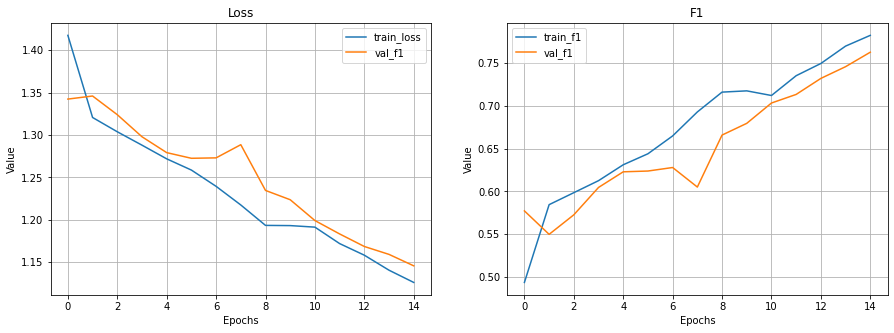

In [346]:
plot_training(losses, train_f1, eval_losses, eval_f1)

Мы видим, что начали переобучаться. Попробуем сделать кол-во этох = 12.

In [347]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# Start

losses = []
eval_losses = []

train_f1 = []
eval_f1 = []

for epoch in tqdm(range(12)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    train_f1.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, train F1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1.append(epoch_val_f1)

    print(f'\n\nEval loss: {epoch_val_loss}, eval f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1
Training...
Train loss: 1.4199532020037577, train F1: 0.47749510774873705
. . . . . . . . . . . . . . . 
Evaluating...


  8%|▊         | 1/12 [00:02<00:28,  2.57s/it]



Eval loss: 1.3459241163991664, eval f1: 0.5525336889889989
. . . . . . . . . . . . . . . 

Epoch 2
Training...
Train loss: 1.322600901399029, train F1: 0.5814171558645762
. . . . . . . . . . . . . . . 
Evaluating...


 17%|█▋        | 2/12 [00:05<00:25,  2.55s/it]



Eval loss: 1.3243295476384407, eval f1: 0.5672375070352624
. . . . . . . . . . . . . . . 

Epoch 3
Training...
Train loss: 1.2984592587980506, train F1: 0.6017204825192282
. . . . . . . . . . . . . . . 
Evaluating...


 25%|██▌       | 3/12 [00:07<00:22,  2.53s/it]



Eval loss: 1.3152147888267127, eval f1: 0.5790988209038755
. . . . . . . . . . . . . . . 

Epoch 4
Training...
Train loss: 1.2802113174847816, train F1: 0.6236545987869506
. . . . . . . . . . . . . . . 
Evaluating...


 33%|███▎      | 4/12 [00:10<00:20,  2.53s/it]



Eval loss: 1.2999635778204368, eval f1: 0.6036987648393116
. . . . . . . . . . . . . . . 

Epoch 5
Training...
Train loss: 1.2556152253934783, train F1: 0.6505218523822419
. . . . . . . . . . . . . . . 
Evaluating...


 42%|████▏     | 5/12 [00:12<00:17,  2.52s/it]



Eval loss: 1.2755015414126598, eval f1: 0.6267546323964196
. . . . . . . . . . . . . . . 

Epoch 6
Training...
Train loss: 1.2185152570406597, train F1: 0.6956131765831551
. . . . . . . . . . . . . . . 
Evaluating...


 50%|█████     | 6/12 [00:15<00:15,  2.52s/it]



Eval loss: 1.2516912748343754, eval f1: 0.6554955083088283
. . . . . . . . . . . . . . . 

Epoch 7
Training...
Train loss: 1.1935871224425154, train F1: 0.7201565555785889
. . . . . . . . . . . . . . . 
Evaluating...


 58%|█████▊    | 7/12 [00:18<00:13,  2.72s/it]



Eval loss: 1.2669429078589391, eval f1: 0.6340539024694123
. . . . . . . . . . . . . . . 

Epoch 8
Training...
Train loss: 1.1813587238799492, train F1: 0.7292889756699131
. . . . . . . . . . . . . . . 
Evaluating...


 67%|██████▋   | 8/12 [00:21<00:11,  2.98s/it]



Eval loss: 1.2604547142982483, eval f1: 0.6390721506445948
. . . . . . . . . . . . . . . 

Epoch 9
Training...
Train loss: 1.1756716468562818, train F1: 0.7327136332041597
. . . . . . . . . . . . . . . 
Evaluating...


 75%|███████▌  | 9/12 [00:24<00:08,  2.83s/it]



Eval loss: 1.194156121598543, eval f1: 0.71273161155464
. . . . . . . . . . . . . . . 

Epoch 10
Training...
Train loss: 1.1598117305263538, train F1: 0.7489807564918309
. . . . . . . . . . . . . . . 
Evaluating...


 83%|████████▎ | 10/12 [00:26<00:05,  2.72s/it]



Eval loss: 1.1714231062979594, eval f1: 0.733260808634932
. . . . . . . . . . . . . . . 

Epoch 11
Training...
Train loss: 1.1351075403766544, train F1: 0.7792318980443423
. . . . . . . . . . . . . . . 
Evaluating...


 92%|█████████▏| 11/12 [00:29<00:02,  2.68s/it]



Eval loss: 1.1628399943783336, eval f1: 0.743297304985297
. . . . . . . . . . . . . . . 

Epoch 12
Training...
Train loss: 1.1168590917434866, train F1: 0.8007175473317708
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 12/12 [00:31<00:00,  2.66s/it]



Eval loss: 1.1555849931535929, eval f1: 0.7519651881969758
. . . . . . . . . . . . . . . 


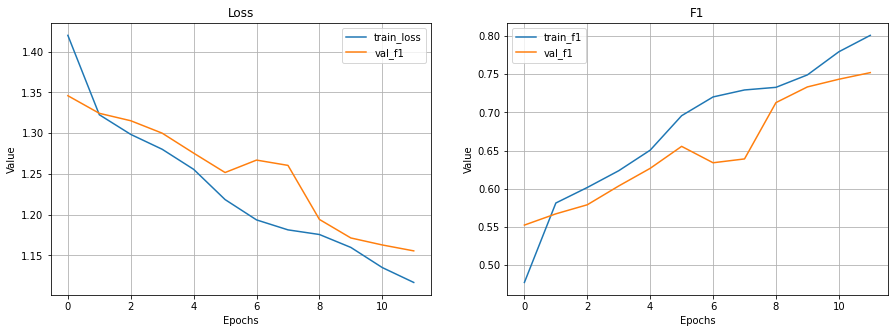

In [348]:
plot_training(losses, train_f1, eval_losses, eval_f1)

А здесь кажется, что модель будто не доучилась


In [349]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# Start

losses = []
eval_losses = []

train_f1 = []
eval_f1 = []

for epoch in tqdm(range(14)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    train_f1.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, train F1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1.append(epoch_val_f1)

    print(f'\n\nEval loss: {epoch_val_loss}, eval f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1
Training...
Train loss: 1.4152986970666337, train F1: 0.4932322243577269
. . . . . . . . . . . . . . . 
Evaluating...


  7%|▋         | 1/14 [00:02<00:33,  2.54s/it]



Eval loss: 1.339754160303269, eval f1: 0.5759053902469412
. . . . . . . . . . . . . . . 

Epoch 2
Training...
Train loss: 1.3212367097536724, train F1: 0.5811317677367224
. . . . . . . . . . . . . . . 
Evaluating...


 14%|█▍        | 2/14 [00:05<00:30,  2.53s/it]



Eval loss: 1.3322208267058768, eval f1: 0.5663250982761383
. . . . . . . . . . . . . . . 

Epoch 3
Training...
Train loss: 1.3024299185569972, train F1: 0.5980104368571277
. . . . . . . . . . . . . . . 
Evaluating...


 21%|██▏       | 3/14 [00:07<00:27,  2.53s/it]



Eval loss: 1.3032939564572634, eval f1: 0.5964345873272332
. . . . . . . . . . . . . . . 

Epoch 4
Training...
Train loss: 1.2854388062268087, train F1: 0.6134213957612373
. . . . . . . . . . . . . . . 
Evaluating...


 29%|██▊       | 4/14 [00:10<00:25,  2.53s/it]



Eval loss: 1.288689496743418, eval f1: 0.6128579449914667
. . . . . . . . . . . . . . . 

Epoch 5
Training...
Train loss: 1.278263939297907, train F1: 0.6208414870854382
. . . . . . . . . . . . . . . 
Evaluating...


 36%|███▌      | 5/14 [00:12<00:22,  2.53s/it]



Eval loss: 1.2863077891133998, eval f1: 0.6105769230936565
. . . . . . . . . . . . . . . 

Epoch 6
Training...
Train loss: 1.2617847024033604, train F1: 0.6382909324615513
. . . . . . . . . . . . . . . 
Evaluating...


 43%|████▎     | 6/14 [00:15<00:20,  2.51s/it]



Eval loss: 1.2694996325639043, eval f1: 0.6356681639695689
. . . . . . . . . . . . . . . 

Epoch 7
Training...
Train loss: 1.240478636195126, train F1: 0.6651174164798161
. . . . . . . . . . . . . . . 
Evaluating...


 50%|█████     | 7/14 [00:17<00:17,  2.51s/it]



Eval loss: 1.2526112599094419, eval f1: 0.6457046603199339
. . . . . . . . . . . . . . . 

Epoch 8
Training...
Train loss: 1.2247894400875319, train F1: 0.6839938030395334
. . . . . . . . . . . . . . . 
Evaluating...


 57%|█████▋    | 8/14 [00:20<00:15,  2.51s/it]



Eval loss: 1.2381108920939647, eval f1: 0.667602470538912
. . . . . . . . . . . . . . . 

Epoch 9
Training...
Train loss: 1.213212303102833, train F1: 0.6927592953046163
. . . . . . . . . . . . . . . 
Evaluating...


 64%|██████▍   | 9/14 [00:22<00:12,  2.51s/it]



Eval loss: 1.2705696742900097, eval f1: 0.6283688938965762
. . . . . . . . . . . . . . . 

Epoch 10
Training...
Train loss: 1.18328400425715, train F1: 0.7262720155389342
. . . . . . . . . . . . . . . 
Evaluating...


 71%|███████▏  | 10/14 [00:25<00:10,  2.51s/it]



Eval loss: 1.2126780643950414, eval f1: 0.6973259405498087
. . . . . . . . . . . . . . . 

Epoch 11
Training...
Train loss: 1.1439162032789292, train F1: 0.7727495108020904
. . . . . . . . . . . . . . . 
Evaluating...


 79%|███████▊  | 11/14 [00:27<00:07,  2.51s/it]



Eval loss: 1.223459158935686, eval f1: 0.6798848962261729
. . . . . . . . . . . . . . . 

Epoch 12
Training...
Train loss: 1.1201108375640765, train F1: 0.7967628831188428
. . . . . . . . . . . . . . . 
Evaluating...


 86%|████████▌ | 12/14 [00:30<00:05,  2.51s/it]



Eval loss: 1.2292812627597447, eval f1: 0.6670058956981575
. . . . . . . . . . . . . . . 

Epoch 13
Training...
Train loss: 1.103223860808159, train F1: 0.8144569470457834
. . . . . . . . . . . . . . . 
Evaluating...


 93%|█████████▎| 13/14 [00:32<00:02,  2.52s/it]



Eval loss: 1.1463806524764013, eval f1: 0.7589135317906847
. . . . . . . . . . . . . . . 

Epoch 14
Training...
Train loss: 1.0996977885564168, train F1: 0.8141715589179296
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 14/14 [00:35<00:00,  2.52s/it]



Eval loss: 1.119230373497427, eval f1: 0.7899354296009036
. . . . . . . . . . . . . . . 


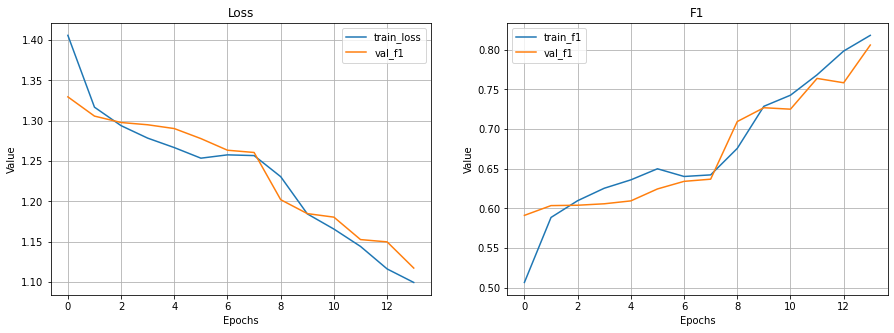

In [283]:
plot_training(losses, train_f1, eval_losses, eval_f1)

Пока что для этой сетки это лучший результат: 0.805 micro F1. На этом запуске кажется, что 14 эпох - маловато. Есть ощущение, что очень зависит от рандомного запуска, от батчей

Решение на huggingface: f1 macro 0.8348, f1 micro 0.9280 на *ruBERT*

Уменьшим learning rate (и увеличим кол-во эпох) 

In [353]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# Start

losses = []
eval_losses = []

train_f1 = []
eval_f1 = []

for epoch in tqdm(range(30)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    train_f1.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, train F1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1.append(epoch_val_f1)

    print(f'\n\nEval loss: {epoch_val_loss}, eval f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1
Training...
Train loss: 1.5247872501747792, train F1: 0.3561643835616438
. . . . . . . . . . . . . . . 
Evaluating...


  3%|▎         | 1/30 [00:05<02:28,  5.13s/it]



Eval loss: 1.4964137025123094, eval f1: 0.36334924204071073
. . . . . . . . . . . . . . . 

Epoch 2
Training...
Train loss: 1.4737817816538354, train F1: 0.4726842791522475
. . . . . . . . . . . . . . . 
Evaluating...


  7%|▋         | 2/30 [00:07<01:40,  3.60s/it]



Eval loss: 1.4619742083723528, eval f1: 0.512738630066823
. . . . . . . . . . . . . . . 

Epoch 3
Training...
Train loss: 1.4400433889807087, train F1: 0.5351842791522474
. . . . . . . . . . . . . . . 
Evaluating...


 10%|█         | 3/30 [00:10<01:23,  3.10s/it]



Eval loss: 1.4295913076748814, eval f1: 0.5537970242274068
. . . . . . . . . . . . . . . 

Epoch 4
Training...
Train loss: 1.4097770795430222, train F1: 0.5585861056362658
. . . . . . . . . . . . . . . 
Evaluating...


 13%|█▎        | 4/30 [00:12<01:14,  2.87s/it]



Eval loss: 1.4032682032480728, eval f1: 0.564395002857612
. . . . . . . . . . . . . . . 

Epoch 5
Training...
Train loss: 1.385898136112788, train F1: 0.572284735773252
. . . . . . . . . . . . . . . 
Evaluating...


 17%|█▋        | 5/30 [00:15<01:08,  2.75s/it]



Eval loss: 1.3833694301382469, eval f1: 0.5657636159962981
. . . . . . . . . . . . . . . 

Epoch 6
Training...
Train loss: 1.3677979794811441, train F1: 0.5811725373137487
. . . . . . . . . . . . . . . 
Evaluating...


 20%|██        | 6/30 [00:17<01:04,  2.67s/it]



Eval loss: 1.3683559424685736, eval f1: 0.5758001123466631
. . . . . . . . . . . . . . . 

Epoch 7
Training...
Train loss: 1.3539172791999226, train F1: 0.5860241354872647
. . . . . . . . . . . . . . . 
Evaluating...


 23%|██▎       | 7/30 [00:20<00:59,  2.61s/it]



Eval loss: 1.356683251631521, eval f1: 0.5794497473831595
. . . . . . . . . . . . . . . 

Epoch 8
Training...
Train loss: 1.342963164799834, train F1: 0.5903049574050729
. . . . . . . . . . . . . . . 
Evaluating...


 27%|██▋       | 8/30 [00:22<00:56,  2.57s/it]



Eval loss: 1.3473049080284842, eval f1: 0.584924199937904
. . . . . . . . . . . . . . . 

Epoch 9
Training...
Train loss: 1.3340759315447175, train F1: 0.5965834962178583
. . . . . . . . . . . . . . . 
Evaluating...


 30%|███       | 9/30 [00:25<00:53,  2.56s/it]



Eval loss: 1.339606063209311, eval f1: 0.5903986524926484
. . . . . . . . . . . . . . . 

Epoch 10
Training...
Train loss: 1.326691895315092, train F1: 0.6002935418799588
. . . . . . . . . . . . . . . 
Evaluating...


 33%|███▎      | 10/30 [00:27<00:50,  2.54s/it]



Eval loss: 1.3331476267236864, eval f1: 0.5945044919087069
. . . . . . . . . . . . . . . 

Epoch 11
Training...
Train loss: 1.3204406146045145, train F1: 0.6028620350306437
. . . . . . . . . . . . . . . 
Evaluating...


 37%|███▋      | 11/30 [00:30<00:48,  2.53s/it]



Eval loss: 1.3276383711473785, eval f1: 0.5986103313247653
. . . . . . . . . . . . . . . 

Epoch 12
Training...
Train loss: 1.3150470643283025, train F1: 0.6085697975877213
. . . . . . . . . . . . . . . 
Evaluating...


 40%|████      | 12/30 [00:32<00:45,  2.52s/it]



Eval loss: 1.3228585032651023, eval f1: 0.6008913532225755
. . . . . . . . . . . . . . . 

Epoch 13
Training...
Train loss: 1.310305830278353, train F1: 0.6105675144826985
. . . . . . . . . . . . . . . 
Evaluating...


 43%|████▎     | 13/30 [00:35<00:42,  2.52s/it]



Eval loss: 1.3186525611111717, eval f1: 0.6036285794999477
. . . . . . . . . . . . . . . 

Epoch 14
Training...
Train loss: 1.3060838291634163, train F1: 0.6145629482726528
. . . . . . . . . . . . . . . 
Evaluating...


 47%|████▋     | 14/30 [00:37<00:40,  2.51s/it]



Eval loss: 1.3149176574971555, eval f1: 0.605558674918474
. . . . . . . . . . . . . . . 

Epoch 15
Training...
Train loss: 1.3022846636706835, train F1: 0.6179876058068994
. . . . . . . . . . . . . . . 
Evaluating...


 50%|█████     | 15/30 [00:40<00:37,  2.52s/it]



Eval loss: 1.3115669732546285, eval f1: 0.6064710836775982
. . . . . . . . . . . . . . . 

Epoch 16
Training...
Train loss: 1.298824775981032, train F1: 0.6191291583183149
. . . . . . . . . . . . . . . 
Evaluating...


 53%|█████▎    | 16/30 [00:42<00:35,  2.54s/it]



Eval loss: 1.308522491559495, eval f1: 0.6096645143345325
. . . . . . . . . . . . . . . 

Epoch 17
Training...
Train loss: 1.2956379586703157, train F1: 0.6208414870854382
. . . . . . . . . . . . . . . 
Evaluating...


 57%|█████▋    | 17/30 [00:45<00:32,  2.52s/it]



Eval loss: 1.3057189370593885, eval f1: 0.6114893318527806
. . . . . . . . . . . . . . . 

Epoch 18
Training...
Train loss: 1.2926783338529335, train F1: 0.6225538158525615
. . . . . . . . . . . . . . . 
Evaluating...


 60%|██████    | 18/30 [00:47<00:30,  2.51s/it]



Eval loss: 1.3031262951175662, eval f1: 0.6124017406119048
. . . . . . . . . . . . . . . 

Epoch 19
Training...
Train loss: 1.289914945217028, train F1: 0.6239807564918309
. . . . . . . . . . . . . . . 
Evaluating...


 63%|██████▎   | 19/30 [00:50<00:27,  2.51s/it]



Eval loss: 1.300691412313141, eval f1: 0.6124017406119048
. . . . . . . . . . . . . . . 

Epoch 20
Training...
Train loss: 1.28727667244602, train F1: 0.6265492496425158
. . . . . . . . . . . . . . . 
Evaluating...


 67%|██████▋   | 20/30 [00:52<00:25,  2.51s/it]



Eval loss: 1.298223466768752, eval f1: 0.614682762509715
. . . . . . . . . . . . . . . 

Epoch 21
Training...
Train loss: 1.284607045726689, train F1: 0.6288323546653469
. . . . . . . . . . . . . . . 
Evaluating...


 70%|███████   | 21/30 [00:55<00:22,  2.52s/it]



Eval loss: 1.2950688887686626, eval f1: 0.6160513756484011
. . . . . . . . . . . . . . . 

Epoch 22
Training...
Train loss: 1.2819190145083215, train F1: 0.630830071560324
. . . . . . . . . . . . . . . 
Evaluating...


 73%|███████▎  | 22/30 [00:57<00:20,  2.52s/it]



Eval loss: 1.292094062714681, eval f1: 0.6178761931666492
. . . . . . . . . . . . . . . 

Epoch 23
Training...
Train loss: 1.2793290587865054, train F1: 0.6331131765831551
. . . . . . . . . . . . . . . 
Evaluating...


 77%|███████▋  | 23/30 [01:00<00:17,  2.52s/it]



Eval loss: 1.2894774710174894, eval f1: 0.6210696238235835
. . . . . . . . . . . . . . . 

Epoch 24
Training...
Train loss: 1.276757901117682, train F1: 0.63568166973384
. . . . . . . . . . . . . . . 
Evaluating...


 80%|████████  | 24/30 [01:02<00:15,  2.52s/it]



Eval loss: 1.2868936723166138, eval f1: 0.6219820325827077
. . . . . . . . . . . . . . . 

Epoch 25
Training...
Train loss: 1.2741253571967557, train F1: 0.6368232222452556
. . . . . . . . . . . . . . . 
Evaluating...


 83%|████████▎ | 25/30 [01:05<00:12,  2.52s/it]



Eval loss: 1.2842029037266751, eval f1: 0.6243683325983312
. . . . . . . . . . . . . . . 

Epoch 26
Training...
Train loss: 1.2712617802293333, train F1: 0.638250162884525
. . . . . . . . . . . . . . . 
Evaluating...


 87%|████████▋ | 26/30 [01:07<00:10,  2.52s/it]



Eval loss: 1.2812663873616796, eval f1: 0.6261931501165794
. . . . . . . . . . . . . . . 

Epoch 27
Training...
Train loss: 1.2678953684083947, train F1: 0.6413894322909177
. . . . . . . . . . . . . . . 
Evaluating...


 90%|█████████ | 27/30 [01:10<00:07,  2.52s/it]



Eval loss: 1.2780435755305046, eval f1: 0.632123807050886
. . . . . . . . . . . . . . . 

Epoch 28
Training...
Train loss: 1.2638212295427715, train F1: 0.6442433135694565
. . . . . . . . . . . . . . . 
Evaluating...


 93%|█████████▎| 28/30 [01:12<00:05,  2.51s/it]



Eval loss: 1.2745837199426915, eval f1: 0.6371420552260685
. . . . . . . . . . . . . . . 

Epoch 29
Training...
Train loss: 1.2591729526106081, train F1: 0.6508072405100958
. . . . . . . . . . . . . . . 
Evaluating...


 97%|█████████▋| 29/30 [01:15<00:02,  2.52s/it]



Eval loss: 1.2708362079884885, eval f1: 0.6467223471968714
. . . . . . . . . . . . . . . 

Epoch 30
Training...
Train loss: 1.2542639361124606, train F1: 0.6642612520962545
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 30/30 [01:18<00:00,  2.60s/it]



Eval loss: 1.2667969256421945, eval f1: 0.6609699608635728
. . . . . . . . . . . . . . . 


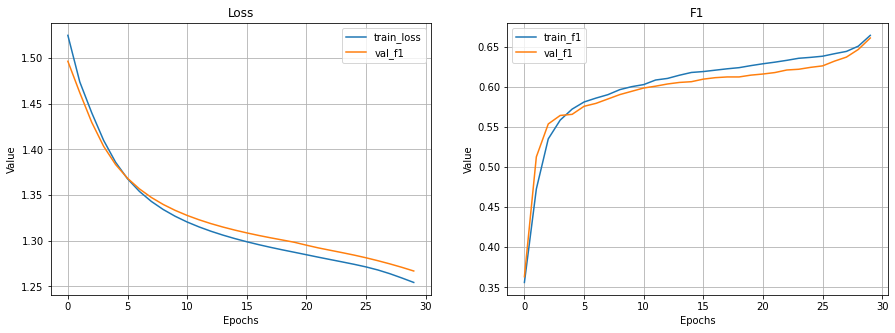

In [354]:
plot_training(losses, train_f1, eval_losses, eval_f1)

Кажется, модель просто не доучивается, но обучение идет очень плавно

In [410]:
model = CNN_w2v(len(word2id), len(symbol2id), 300, 15)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# Start

losses = []
eval_losses = []

train_f1 = []
eval_f1 = []

for epoch in tqdm(range(35)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    train_f1.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, train F1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1.append(epoch_val_f1)

    print(f'\n\nEval loss: {epoch_val_loss}, eval f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1
Training...
Train loss: 1.471737439229608, train F1: 0.4167482060928867
. . . . . . . . . . . . . . . 
Evaluating...


  3%|▎         | 1/35 [00:02<01:25,  2.52s/it]



Eval loss: 1.400982953336117, eval f1: 0.5512703537505909
. . . . . . . . . . . . . . . 

Epoch 2
Training...
Train loss: 1.3676349882665835, train F1: 0.5551614481020192
. . . . . . . . . . . . . . . 
Evaluating...


  6%|▌         | 2/35 [00:05<01:23,  2.54s/it]



Eval loss: 1.3587334469287065, eval f1: 0.5456906232955682
. . . . . . . . . . . . . . . 

Epoch 3
Training...
Train loss: 1.324872113798307, train F1: 0.5848825829758492
. . . . . . . . . . . . . . . 
Evaluating...


  9%|▊         | 3/35 [00:07<01:21,  2.55s/it]



Eval loss: 1.3339882593085295, eval f1: 0.5727119595900069
. . . . . . . . . . . . . . . 

Epoch 4
Training...
Train loss: 1.3057997947958506, train F1: 0.6014350943913743
. . . . . . . . . . . . . . . 
Evaluating...


 11%|█▏        | 4/35 [00:10<01:19,  2.57s/it]



Eval loss: 1.318110834943117, eval f1: 0.5905039303929266
. . . . . . . . . . . . . . . 

Epoch 5
Training...
Train loss: 1.2926263371014703, train F1: 0.6134213957612373
. . . . . . . . . . . . . . . 
Evaluating...


 14%|█▍        | 5/35 [00:12<01:17,  2.58s/it]



Eval loss: 1.306821112215084, eval f1: 0.5996280179841675
. . . . . . . . . . . . . . . 

Epoch 6
Training...
Train loss: 1.2804220623621658, train F1: 0.6243069141967111
. . . . . . . . . . . . . . . 
Evaluating...


 17%|█▋        | 6/35 [00:15<01:15,  2.59s/it]



Eval loss: 1.2917956688108236, eval f1: 0.6412128018636774
. . . . . . . . . . . . . . . 

Epoch 7
Training...
Train loss: 1.2518395479411295, train F1: 0.664505870647082
. . . . . . . . . . . . . . . 
Evaluating...


 20%|██        | 7/35 [00:17<01:11,  2.57s/it]



Eval loss: 1.2594221799913115, eval f1: 0.6649354296009036
. . . . . . . . . . . . . . . 

Epoch 8
Training...
Train loss: 1.2249598745341714, train F1: 0.6950424003274474
. . . . . . . . . . . . . . . 
Evaluating...


 23%|██▎       | 8/35 [00:20<01:08,  2.56s/it]



Eval loss: 1.2464579361198593, eval f1: 0.669953677776086
. . . . . . . . . . . . . . . 

Epoch 9
Training...
Train loss: 1.207133642342537, train F1: 0.717588062427904
. . . . . . . . . . . . . . . 
Evaluating...


 26%|██▌       | 9/35 [00:23<01:06,  2.55s/it]



Eval loss: 1.2375823154936743, eval f1: 0.6749719259512685
. . . . . . . . . . . . . . . 

Epoch 10
Training...
Train loss: 1.1931341355794096, train F1: 0.7261497062635204
. . . . . . . . . . . . . . . 
Evaluating...


 29%|██▊       | 10/35 [00:25<01:03,  2.54s/it]



Eval loss: 1.2267744954485094, eval f1: 0.6863770354403197
. . . . . . . . . . . . . . . 

Epoch 11
Training...
Train loss: 1.182958917258537, train F1: 0.7327136332041597
. . . . . . . . . . . . . . . 
Evaluating...


 31%|███▏      | 11/35 [00:28<01:01,  2.54s/it]



Eval loss: 1.21350636316912, eval f1: 0.700519371206743
. . . . . . . . . . . . . . . 

Epoch 12
Training...
Train loss: 1.1747638101447118, train F1: 0.7372798432498218
. . . . . . . . . . . . . . . 
Evaluating...


 34%|███▍      | 12/35 [00:30<00:58,  2.54s/it]



Eval loss: 1.202377734393099, eval f1: 0.7087310500388598
. . . . . . . . . . . . . . . 

Epoch 13
Training...
Train loss: 1.1646688814576902, train F1: 0.7484099802361232
. . . . . . . . . . . . . . . 
Evaluating...


 37%|███▋      | 13/35 [00:33<00:56,  2.55s/it]



Eval loss: 1.1966628527989354, eval f1: 0.7091872544184218
. . . . . . . . . . . . . . . 

Epoch 14
Training...
Train loss: 1.1494932563881897, train F1: 0.7758887802084832
. . . . . . . . . . . . . . . 
Evaluating...


 40%|████      | 14/35 [00:35<00:53,  2.55s/it]



Eval loss: 1.185358642226588, eval f1: 0.7251544077030934
. . . . . . . . . . . . . . . 

Epoch 15
Training...
Train loss: 1.135036616837053, train F1: 0.7947243966468392
. . . . . . . . . . . . . . . 
Evaluating...


 43%|████▎     | 15/35 [00:38<00:51,  2.55s/it]



Eval loss: 1.1721410477248422, eval f1: 0.7437535093648591
. . . . . . . . . . . . . . . 

Epoch 16
Training...
Train loss: 1.1227497687078503, train F1: 0.8080968685346107
. . . . . . . . . . . . . . . 
Evaluating...


 46%|████▌     | 16/35 [00:40<00:48,  2.56s/it]



Eval loss: 1.1574990727605612, eval f1: 0.7615454801677788
. . . . . . . . . . . . . . . 

Epoch 17
Training...
Train loss: 1.1127157812793504, train F1: 0.8129484667081267
. . . . . . . . . . . . . . . 
Evaluating...


 49%|████▊     | 17/35 [00:43<00:45,  2.55s/it]



Eval loss: 1.1467535621928473, eval f1: 0.7688447502407715
. . . . . . . . . . . . . . . 

Epoch 18
Training...
Train loss: 1.105967523844819, train F1: 0.8175146767537887
. . . . . . . . . . . . . . . 
Evaluating...


 51%|█████▏    | 18/35 [00:46<00:43,  2.57s/it]



Eval loss: 1.1393447814196567, eval f1: 0.773862998415954
. . . . . . . . . . . . . . . 

Epoch 19
Training...
Train loss: 1.1022666869642528, train F1: 0.8184116112587114
. . . . . . . . . . . . . . . 
Evaluating...


 54%|█████▍    | 19/35 [00:48<00:40,  2.55s/it]



Eval loss: 1.1298306345069495, eval f1: 0.7843556991458809
. . . . . . . . . . . . . . . 

Epoch 20
Training...
Train loss: 1.1059939537418488, train F1: 0.8112769080623644
. . . . . . . . . . . . . . . 
Evaluating...


 57%|█████▋    | 20/35 [00:51<00:38,  2.55s/it]



Eval loss: 1.125453238069576, eval f1: 0.7843556991458809
. . . . . . . . . . . . . . . 

Epoch 21
Training...
Train loss: 1.097192656776132, train F1: 0.8181262231308576
. . . . . . . . . . . . . . . 
Evaluating...


 60%|██████    | 21/35 [00:53<00:35,  2.55s/it]



Eval loss: 1.1194767360269589, eval f1: 0.7898301517006254
. . . . . . . . . . . . . . . 

Epoch 22
Training...
Train loss: 1.093365047075977, train F1: 0.8201239400258348
. . . . . . . . . . . . . . . 
Evaluating...


 63%|██████▎   | 22/35 [00:56<00:33,  2.55s/it]



Eval loss: 1.1285717496036614, eval f1: 0.7843556991458809
. . . . . . . . . . . . . . . 

Epoch 23
Training...
Train loss: 1.0902262139538108, train F1: 0.8226924331765196
. . . . . . . . . . . . . . . 
Evaluating...


 66%|██████▌   | 23/35 [00:58<00:30,  2.55s/it]



Eval loss: 1.1360323859827361, eval f1: 0.7728453117565517
. . . . . . . . . . . . . . . 

Epoch 24
Training...
Train loss: 1.0807435371015714, train F1: 0.8329664057792594
. . . . . . . . . . . . . . . 
Evaluating...


 69%|██████▊   | 24/35 [01:01<00:27,  2.55s/it]



Eval loss: 1.147013896573199, eval f1: 0.7641774285448729
. . . . . . . . . . . . . . . 

Epoch 25
Training...
Train loss: 1.0739201759094517, train F1: 0.8398157208477526
. . . . . . . . . . . . . . . 
Evaluating...


 71%|███████▏  | 25/35 [01:03<00:25,  2.55s/it]



Eval loss: 1.1606498887069034, eval f1: 0.7472978665010772
. . . . . . . . . . . . . . . 

Epoch 26
Training...
Train loss: 1.0681289965159273, train F1: 0.8440965427655608
. . . . . . . . . . . . . . . 
Evaluating...


 74%|███████▍  | 26/35 [01:06<00:22,  2.54s/it]



Eval loss: 1.1117551017851726, eval f1: 0.7971294217736181
. . . . . . . . . . . . . . . 

Epoch 27
Training...
Train loss: 1.0645145352028276, train F1: 0.8463796477883918
. . . . . . . . . . . . . . . 
Evaluating...


 77%|███████▋  | 27/35 [01:09<00:20,  2.57s/it]



Eval loss: 1.1024735783138415, eval f1: 0.8076221225035451
. . . . . . . . . . . . . . . 

Epoch 28
Training...
Train loss: 1.0594158251535948, train F1: 0.8526581866011772
. . . . . . . . . . . . . . . 
Evaluating...


 80%|████████  | 28/35 [01:11<00:17,  2.57s/it]



Eval loss: 1.0943527674152904, eval f1: 0.8121841662991656
. . . . . . . . . . . . . . . 

Epoch 29
Training...
Train loss: 1.0513659274741396, train F1: 0.8629729287809433
. . . . . . . . . . . . . . . 
Evaluating...


 83%|████████▎ | 29/35 [01:14<00:15,  2.58s/it]



Eval loss: 1.0845059178171366, eval f1: 0.8254140933064649
. . . . . . . . . . . . . . . 

Epoch 30
Training...
Train loss: 1.0423344316547865, train F1: 0.8738176776393908
. . . . . . . . . . . . . . . 
Evaluating...


 86%|████████▌ | 30/35 [01:16<00:12,  2.58s/it]



Eval loss: 1.0764171050412812, eval f1: 0.8381878159342021
. . . . . . . . . . . . . . . 

Epoch 31
Training...
Train loss: 1.0340184455048549, train F1: 0.8849478146256922
. . . . . . . . . . . . . . . 
Evaluating...


 89%|████████▊ | 31/35 [01:19<00:10,  2.57s/it]



Eval loss: 1.0711196704502524, eval f1: 0.8463994947663189
. . . . . . . . . . . . . . . 

Epoch 32
Training...
Train loss: 1.0270625742058777, train F1: 0.8903701890549159
. . . . . . . . . . . . . . . 
Evaluating...


 91%|█████████▏| 32/35 [01:21<00:07,  2.58s/it]



Eval loss: 1.0681612504659779, eval f1: 0.8459432903867569
. . . . . . . . . . . . . . . 

Epoch 33
Training...
Train loss: 1.0216579535236097, train F1: 0.8946510109727241
. . . . . . . . . . . . . . . 
Evaluating...


 94%|█████████▍| 33/35 [01:24<00:05,  2.57s/it]



Eval loss: 1.0652870944816701, eval f1: 0.847768107905005
. . . . . . . . . . . . . . . 

Epoch 34
Training...
Train loss: 1.0168487266318438, train F1: 0.899787997274094
. . . . . . . . . . . . . . . 
Evaluating...


 97%|█████████▋| 34/35 [01:26<00:02,  2.56s/it]



Eval loss: 1.063032400869105, eval f1: 0.8546111735984356
. . . . . . . . . . . . . . . 

Epoch 35
Training...
Train loss: 1.0113035073019054, train F1: 0.9063519242147332
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 35/35 [01:29<00:00,  2.56s/it]



Eval loss: 1.0612678379908096, eval f1: 0.8555235823575598
. . . . . . . . . . . . . . . 


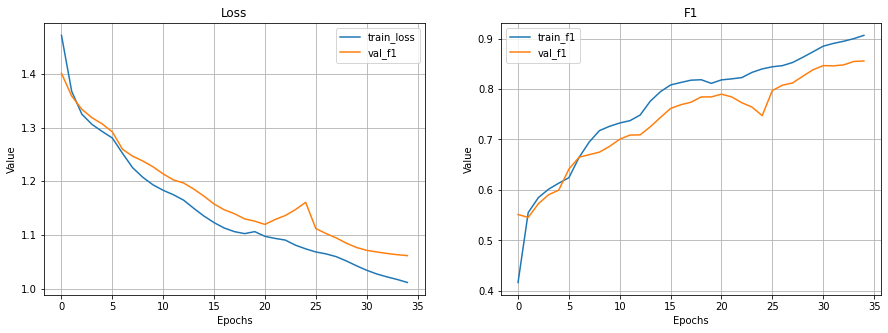

In [411]:
plot_training(losses, train_f1, eval_losses, eval_f1)

Итак, в итоге мы имеет 0.855 f1

# Test data & Classification report

Сделаем финальную сетку и оценим качество по классам

In [412]:
y_test = []
pred_test = []

model.eval()

with torch.no_grad():
    for i, (x_word, x_symbol, y) in enumerate(test_loader):

      y = [x.item() for x in y.squeeze()] # 0D target tensor expected, convert items from tensor to torch
      y_test.extend(y)

      pred = model(x_word, x_symbol).cpu().numpy().argmax(axis=1)
      pred_test.extend(pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [413]:
print(len(pred_test), len(y_test))

2189 2189


In [414]:
labels = {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}

In [415]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, pred_test, target_names=labels.values()))

              precision    recall  f1-score   support

         joy       0.88      0.96      0.92       776
     sadness       0.89      0.93      0.91       676
    surprise       0.88      0.92      0.90       284
        fear       0.89      0.70      0.79       271
       anger       0.69      0.49      0.57       182

    accuracy                           0.87      2189
   macro avg       0.85      0.80      0.82      2189
weighted avg       0.87      0.87      0.87      2189



In [417]:
from sklearn.metrics import f1_score


print('Macro: ', f1_score(y_test, pred_test, average='macro'))
print('Micro: ', f1_score(y_test, pred_test, average='micro'))
print('Weigh: ', f1_score(y_test, pred_test, average='weighted'))

Macro:  0.8172687643632669
Micro:  0.8734582000913659
Weigh:  0.8677059907520305


Повторим, что решение на huggingface: f1 macro 0.8348, f1 micro 0.9280 на *ruBERT*.

А у нас f1 macro 0.817, f1 micro 0.873

Так что мы не так сильно отстали от берта:)

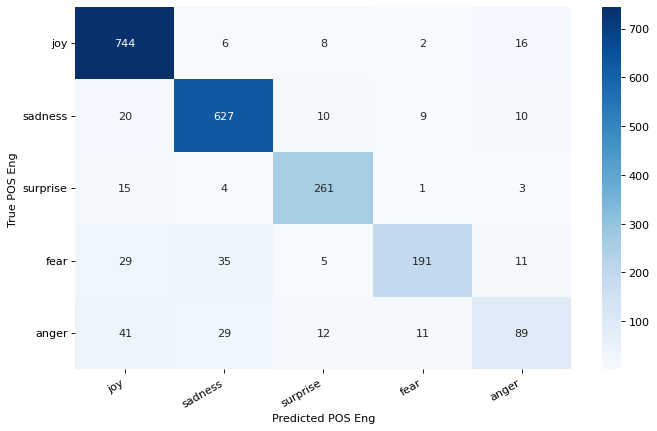

In [420]:
from matplotlib.pyplot import figure

def show_confusion_matrix(confusion_matrix):
  figure(figsize=(10, 6), dpi=80)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True POS Eng')
  plt.xlabel('Predicted POS Eng');


cm = confusion_matrix(y_test, pred_test)
df_cm = pd.DataFrame(cm, index=labels.values(), columns=labels.values())
show_confusion_matrix(df_cm)

Итак, у нас не сбалансированный датасет, больше всего joy и sadness, по ним f1 0.92 и 0.91 соответственно. Хуже всего anger (0.57 f1) - но и его меньше всего. Его модель путает боьше всего с самыми большими классами: joy и sadness. Что можно улучшить? Попробовать поиграться с архитектурой, попробовать разбить сначала на 3 класса (joy, sadness и остальное) и потом внутри 3 класса отдельно решать - хотя данных совсем мало.